In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from pathlib import Path
import xtrack as xt
import xpart as xp
import xcoll as xc
import xobjects as xo

In [11]:
def df_to_delta(df):
    sps_gtr = 17.95
    sps_g0 = 27.643
    f0 = 200e6
    eta = 1/sps_gtr**2 - 1/sps_g0**2
    return -df/(f0*eta)

In [7]:
num_particles = 1000
# num_turns = 6000
num_turns = 6000
plane = 'DPneg'
sweep = 6000
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
sweep_per_turn = sweep / num_turns
nemitt_x = 2e-6
nemitt_y = 2e-6
# num_turns = 1_000_000

In [3]:
line = xt.Line.from_json('../../injection_lines/sps_q20_inj.json')
tt = line.get_table()
tw = line.twiss()

context = xo.ContextCpu()
line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

Loading line from dict:   0%|          | 0/4037 [00:00<?, ?it/s]

Done loading line from dict.           


In [8]:
part = xp.generate_matched_gaussian_bunch(nemitt_x=nemitt_x,
                                          nemitt_y=nemitt_y,
                                          sigma_z=0.224, num_particles=num_particles, line=line)

*** Maximum RMS bunch length 0.2361011034682247m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004868
--> Emittance: 0.4451512317969801


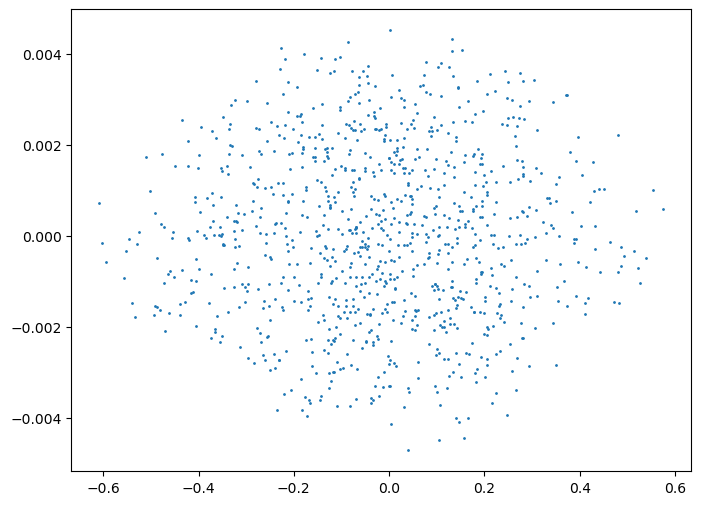

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.scatter(part.zeta, part.delta, s=1)

In [29]:
env = line.env
# monitor1 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns, n_repetitions=1, repetition_period=10000, particle_id_range=(num_particles-5, num_particles))
# monitor2 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
monitor3 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)

# env.elements['monitor_qd31110'] = monitor1
# env.elements['monitor_qf31010'] = monitor2
env.elements['monitor_start'] = monitor3
# line.insert([env.place('monitor_qd31110', at='qd.31110@end'), env.place('monitor_qf31010', at='qf.31010@end'), env.place('monitor_start', at=0)])
line.insert([env.place('monitor_start', at=0)])

KeyboardInterrupt: 

In [40]:
n_r = 20
n_theta = 10
x_normalized, y_normalized, r_xy, theta_xy = xp.generate_2D_polar_grid(
    r_range=(0, 40.), # beam sigmas
    theta_range=(0, np.pi/2),
    nr=n_r, ntheta=n_theta)

delta_init = df_to_delta(5000*sweep_per_turn)#tw.particle_on_co.delta

part = line.build_particles(
    x_norm=x_normalized, px_norm=0,
    y_norm=y_normalized, py_norm=0,
    nemitt_x=2e-6, nemitt_y=2e-6, # normalized emittances
    delta=delta_init)

In [41]:
delta_init

-0.013927811479294252

In [42]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

line.track(part, num_turns=num_turns, time=True, with_progress=True)

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/1000000 [00:00<?, ?it/s]

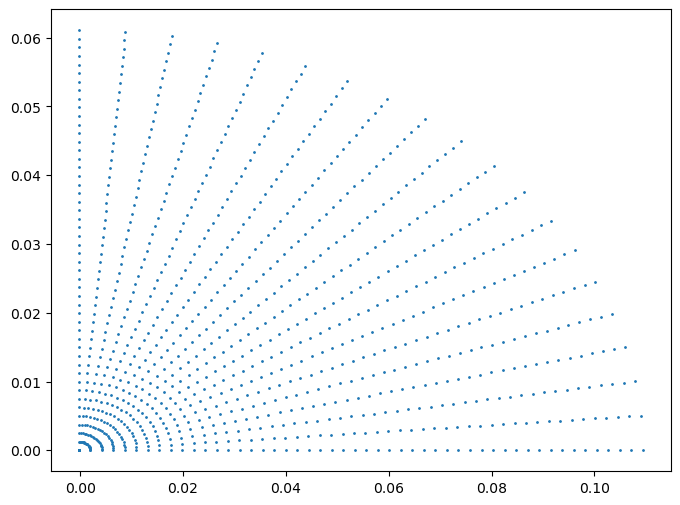

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.scatter(part.x, part.y, s=1)

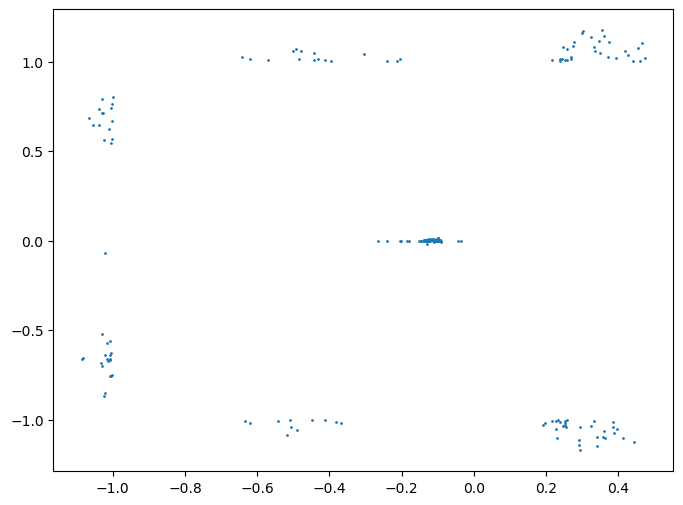

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.scatter(part.x, part.y, s=1)

In [45]:
np.unique(part.state, return_counts=True)

(array([-1,  1]), array([124,  76]))

In [67]:
np.unique(part.at_turn[part.state < 1], return_counts=True)

(array([    63,     76,    112,    129,    134,    139,    143,    150,
           152,    160,    163,    166,    169,    170,    172,    182,
           186,    193,    196,    203,    219,    223,    227,    230,
           246,    252,    262,    280,    283,    285,    296,    320,
           326,    333,    356,    357,    377,    383,    386,    393,
           410,    414,    417,    421,    429,    436,    449,    472,
           477,    479,    497,    536,    556,    577,    579,    588,
           594,    620,    624,    628,    631,    637,    643,    662,
           669,    681,    716,    732,    756,    789,    796,    840,
           842,    854,    857,    874,    917,    925,    960,    974,
          1011,   1031,   1048,   1075,   1149,   1213,   1224,   1266,
          1268,   1276,   1307,   1376,   1403,   1444,   1447,   1459,
          1516,   1518,   1640,   1692,   1734,   1966,   2011,   2034,
          2035,   2216,   2391,   2563,   3331,   3726,   4219, 

In [68]:
part_init = line.build_particles(
    x_norm=x_normalized, px_norm=0,
    y_norm=y_normalized, py_norm=0,
    nemitt_x=2e-6, nemitt_y=2e-6, # normalized emittances
    delta=delta_init)

In [70]:
pids = part.particle_id[part.state < 1]

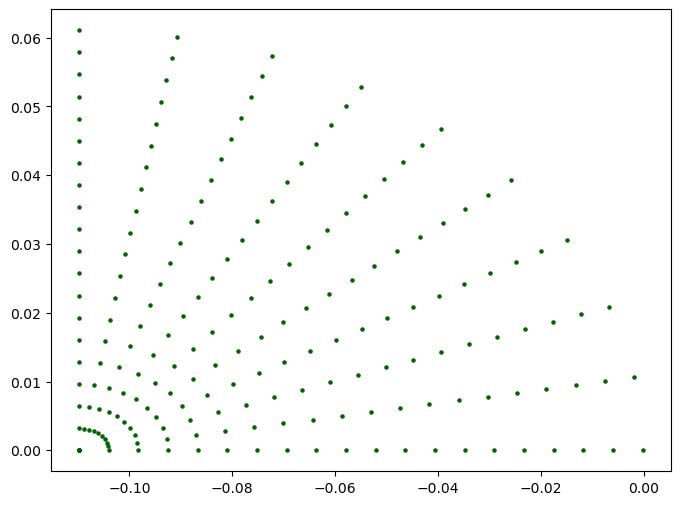

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.scatter(part_init.x, part_init.y, s=5, color='darkgreen', label='Initial')
# ax.scatter(part.x[pids], part.y[pids], s=5, color='orange', label='Final')

In [12]:
n_r = 20
n_theta = 10
x_normalized, y_normalized, r_xy, theta_xy = xp.generate_2D_polar_grid(
    r_range=(0, 40.), # beam sigmas
    theta_range=(0, np.pi/2),
    nr=n_r, ntheta=n_theta)

delta_init = df_to_delta(5000*sweep_per_turn)#tw.particle_on_co.delta

part_init = line.build_particles(
    x_norm=x_normalized, px_norm=0,
    y_norm=y_normalized, py_norm=0,
    nemitt_x=2e-6, nemitt_y=2e-6, # normalized emittances
    delta=delta_init)

In [13]:
np.unique(part_init.zeta, return_counts=True)

(array([-1.70863964e-16, -1.70863436e-16, -1.70862908e-16, -1.70862380e-16,
        -1.70861852e-16, -1.70861324e-16, -1.70860796e-16, -1.70860268e-16,
        -1.70859740e-16, -1.70859212e-16, -1.70858684e-16, -1.70858155e-16,
        -1.70857627e-16, -1.70857099e-16, -1.70856571e-16, -1.70856043e-16,
        -1.70855515e-16, -1.70854987e-16, -1.70854459e-16, -1.70853931e-16,
         1.49745701e-06,  2.94941455e-06,  2.99491402e-06,  4.31175562e-06,
         4.49237103e-06,  5.54308617e-06,  5.89882910e-06,  5.98982804e-06,
         6.60599286e-06,  7.46817980e-06,  7.48728505e-06,  8.10344987e-06,
         8.49250072e-06,  8.62351123e-06,  8.62351123e-06,  8.84824364e-06,
         8.98474206e-06,  1.04821991e-05,  1.10861723e-05,  1.17976582e-05,
         1.19796561e-05,  1.29352668e-05,  1.32119857e-05,  1.34771131e-05,
         1.47470727e-05,  1.49363596e-05,  1.49745701e-05,  1.62068997e-05,
         1.64720271e-05,  1.66292585e-05,  1.69850014e-05,  1.72470225e-05,
         1.7

In [ ]:
part2 = part.copy()
part2.sort(interleave_lost_particles=True)

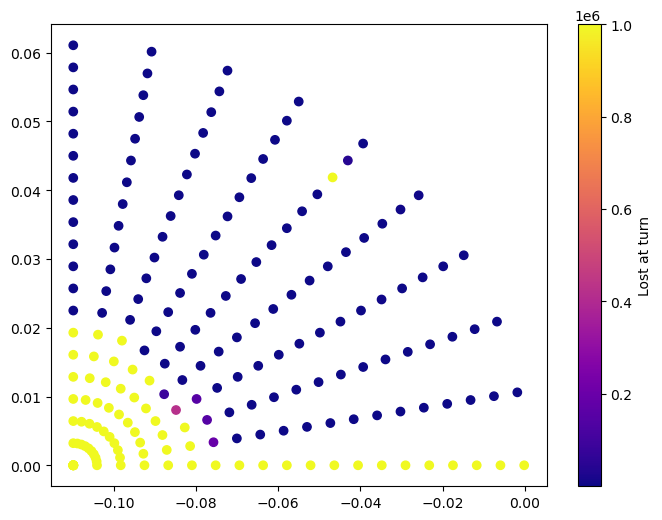

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

sc = ax.scatter(part_init.x, part_init.y, c = part2.at_turn, cmap='plasma')
fig.colorbar(sc, ax=ax, label='Lost at turn')

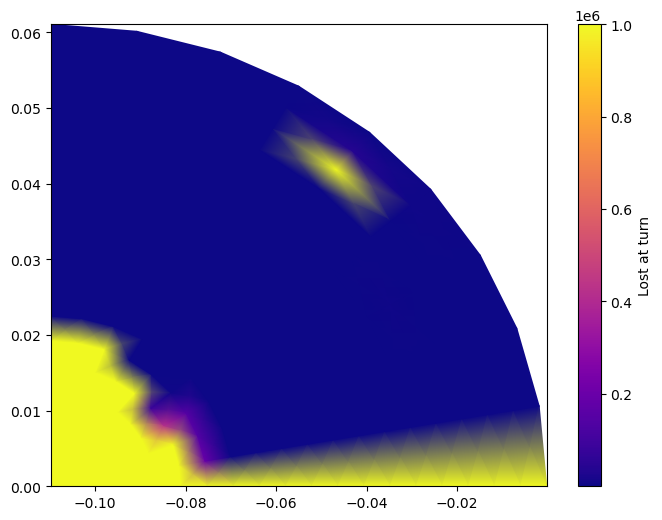

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
# alive_pids = part.particle_id[part.state == 1]
sc = ax.pcolormesh(part_init.x.reshape(n_r,n_theta), part_init.y.reshape(n_r,n_theta), part2.at_turn.reshape(n_r,n_theta), shading='gouraud', cmap='plasma')
fig.colorbar(sc, ax=ax, label='Lost at turn')

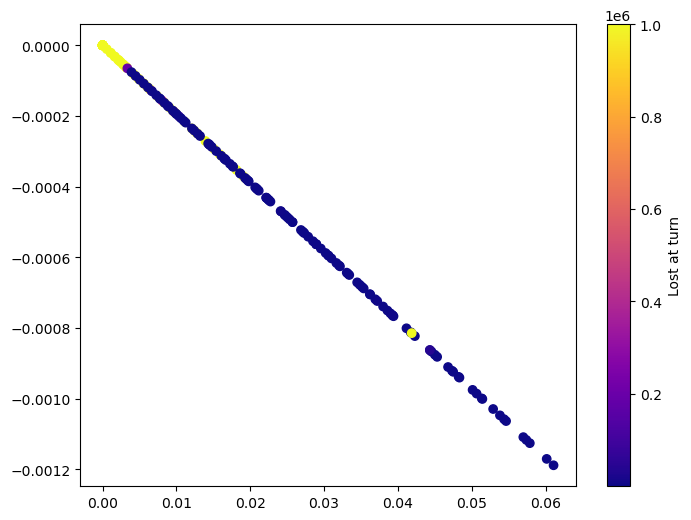

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

sc = ax.scatter(part_init.y, part_init.py, c = part2.at_turn, cmap='plasma')
fig.colorbar(sc, ax=ax, label='Lost at turn')

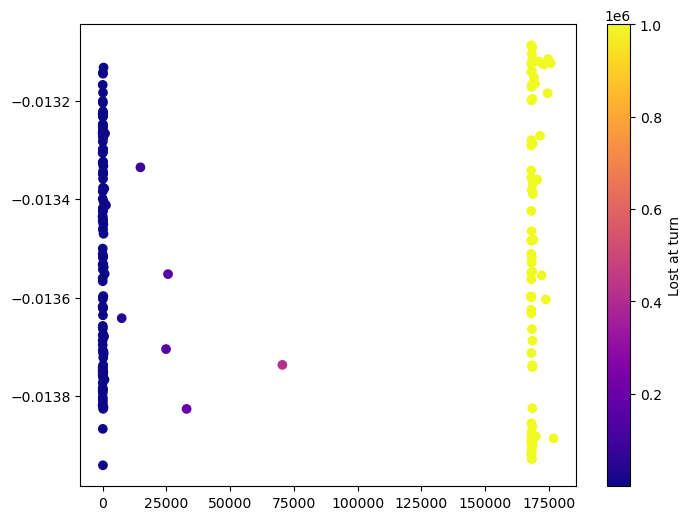

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

sc = ax.scatter(part2.zeta, part2.delta, c = part2.at_turn, cmap='plasma')
fig.colorbar(sc, ax=ax, label='Lost at turn')

In [1]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
# alive_pids = part.particle_id[part.state == 1]
sc = ax.pcolormesh(part_init.x.reshape(n_r,n_theta), part_init.y.reshape(n_r,n_theta), part2.zeta.reshape(n_r,n_theta), shading='gouraud', cmap='plasma')
fig.colorbar(sc, ax=ax, label='zeta')

NameError: name 'plt' is not defined

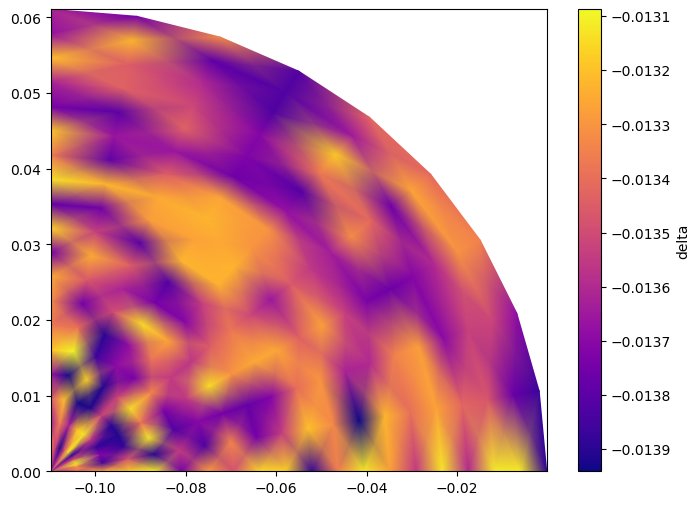

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
# alive_pids = part.particle_id[part.state == 1]
sc = ax.pcolormesh(part_init.x.reshape(n_r,n_theta), part_init.y.reshape(n_r,n_theta), part2.delta.reshape(n_r,n_theta), shading='gouraud', cmap='plasma')
fig.colorbar(sc, ax=ax, label='delta')